# Laboratory 2

In this second laboratory you will implement and train a simple softmax classifier for images.
Another important aspect that we'll be discussing today is how to properly evaluate a classifier.




In [2]:
import os
import sys
import torch
import numpy as np
from functools import reduce
#from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/My Drive

In [ ]:
%mkdir cvdl2_lab2
%cd cvdl2_lab2

In [ ]:
![ -d cvdl_lab2_students ] || git clone https://github.com/dianalauraborza/cvdl_lab2_students.git

# allow "hot-reloading" of modules
%load_ext autoreload
%autoreload 2
# needed for inline plots in some contexts
%matplotlib inline
%cd cvdl_lab2_students

In [3]:
files.view('lab2/activations.py')


NameError: name 'files' is not defined

## Warm-up. numpy exercise

Let's start by implementing the softmax function. This function takes as input an array of *N* arbitrary numbers and normalizes the array such that the output is a probability distribution.


\begin{equation}
softmax(x)_i = \frac{e^{x_i}}{\sum_{j = 0}^{j = N} e^{x_j}}
\end{equation}

In the file *activations.py* write the implementation of the softmax function.

**Short discussion about softmax numerical stability.** You can also check this [post](https://ogunlao.github.io/2020/04/26/you_dont_really_know_softmax.html).

This code is found in _activations.py_ .

In [3]:
from activations import softmax

# validate softmax
# let's check that you obtained the same values
# as the softmax implementation in torch
arr = np.asarray([2, 4, 10, 100, 2.0])   
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax(arr)))
arr = np.asarray([0.0, 0, 0, 1, 0])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax(arr)))
arr = np.asarray([-750.0, 23, 9, 10, 230])
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax(arr)))
arr = np.ones((4, ))
assert (np.allclose(torch.nn.functional.softmax(torch.from_numpy(arr), dim=0).numpy(), softmax(arr)))
arr = np.zeros((4, ))

*Softmax temperature* is a concept that we'll be using later in this course.
The *softmax temperature* is a hyper-parameter (positive number) which scales the input of the softmax function to modify the output probabilities.


\begin{equation}
s(x, T)_i = \frac{e^{x_i/T}}{\sum_{j = 0}^{j = N} e^{x_j/T}}
\end{equation}

Now modify your implementation of the softmax function such that it also takes as input the softmax temperature (a positive floating point number). If this parameter is not specified, it should default to 1.


Now let's visualise what is the effect of the softmax temperature.
Given the input vector *x = [100, 2, -150, 75, 99, 3]* , plot the original vector and the softmax with temperatures $ T \in \{0.25, 0.75, 1, 1.5, 2, 5, 10, 20, 30\} $.

You can use a bar plot for this. The title for each plot should be the value of the softmax temperature. Also, make sure that for all the plots the range of the *y* axis is set to (0, 1).

This code is found in _activations.py_ .


[3.72007598e-044 8.75651076e-027 5.87928270e-105 1.00000000e+000
 3.77513454e-011 2.85242334e-096]
[3.33711831e-15 2.06046241e-09 1.80424613e-35 9.99664648e-01
 3.35350130e-04 1.41772608e-32]
[1.38536000e-11 3.05145846e-07 8.73485655e-27 9.97527072e-01
 2.47262240e-03 1.29636765e-24]
[5.67357545e-08 4.45813670e-05 4.17175624e-18 9.81969955e-01
 1.79854071e-02 1.16941106e-16]
[3.54803150e-06 5.26574564e-04 8.90910411e-14 9.52069146e-01
 4.74007317e-02 1.08535107e-12]
[4.96261192e-03 3.66690179e-02 4.52531631e-06 7.36516913e-01
 2.21834631e-01 1.23010851e-05]
[0.04411767 0.11992426 0.00133224 0.53746325 0.29496609 0.00219649]
[0.10962895 0.18074759 0.01905066 0.38264264 0.28346864 0.02446153]
[0.13774578 0.19223972 0.04289448 0.31694971 0.25949648 0.05067384]


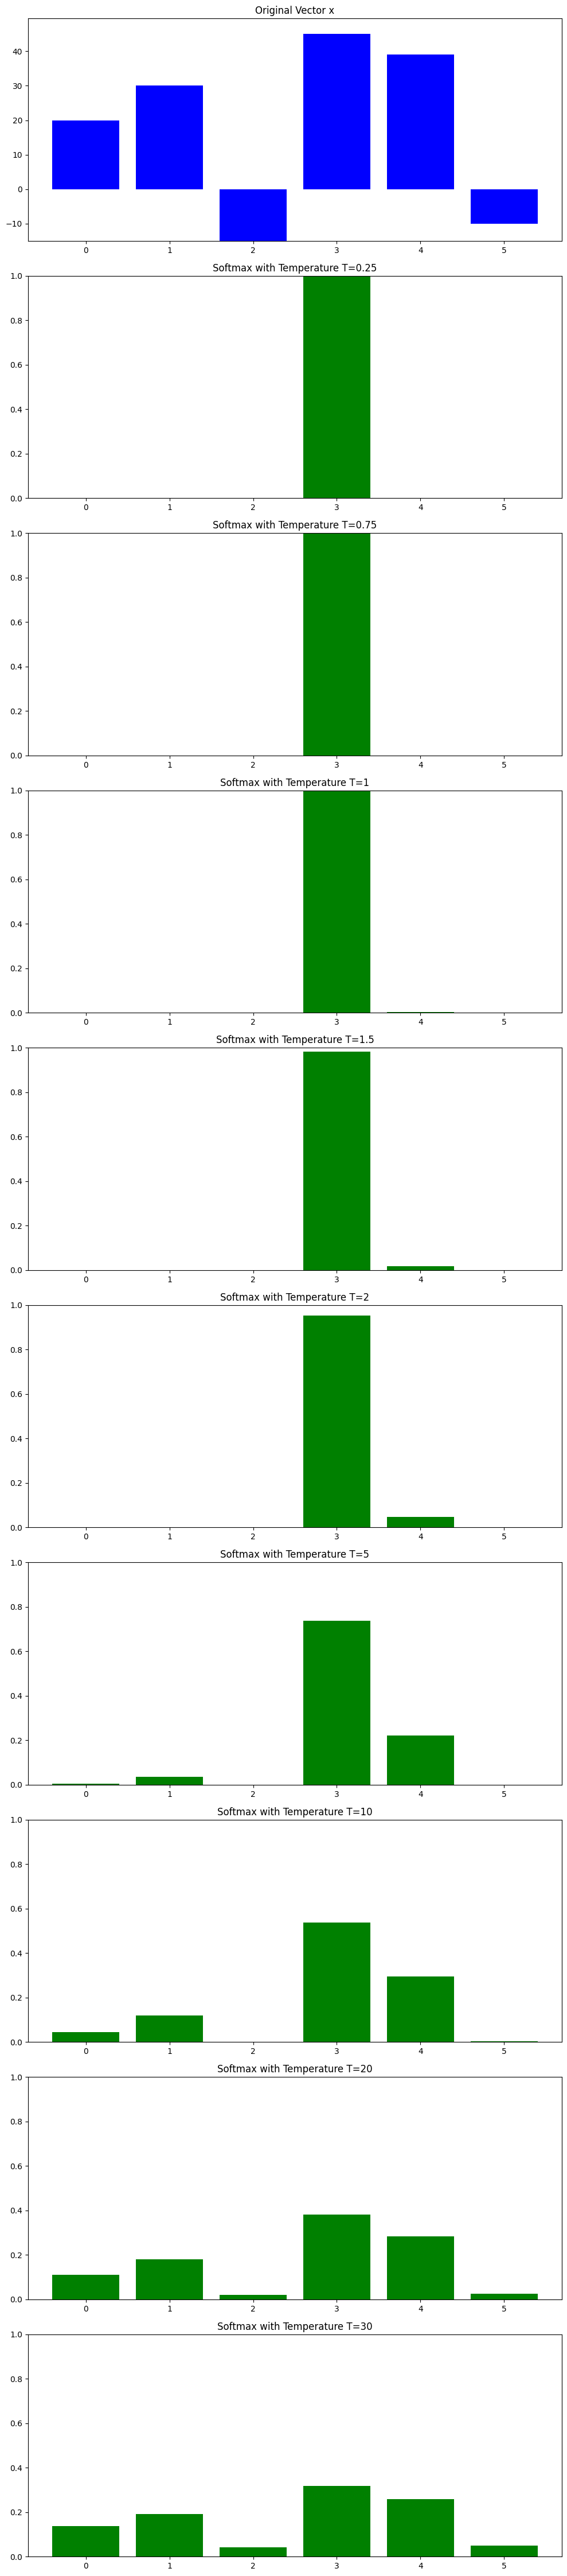

In [4]:
# your code here
import matplotlib.pyplot as plt
from activations import softmax
x = np.asarray([20, 30, -15, 45, 39, -10])
T = [0.25, 0.75, 1, 1.5, 2, 5, 10, 20, 30]

def plot_softmax_effect(x, T):
  fig, axs = plt.subplots(len(T)+1, 1, figsize=(10, 5*len(T)))
  
  axs[0].bar(range(len(x)), x, color = 'blue')
  axs[0].set_title("Original Vector x")
  axs[0].set_ylim(min(x), max(x)*1.1)
  
  for idx, T_elem in enumerate(T):
    softmax_temperature_result = softmax(x, T_elem)
    print(softmax_temperature_result)
    axs[idx+1].bar(range(len(softmax_temperature_result)), softmax_temperature_result, color='green')
    axs[idx+1].set_title(f"Softmax with Temperature T={T_elem}")
    axs[idx + 1].set_ylim(0, 1)
  
  plt.tight_layout()
  plt.show()
    
plot_softmax_effect(x, T)



Analyse the plots and answer the following questions:
* What happens when we use a large number for the softmax temperature?

using a larger number for the softmax temperature leads to the output distribution of the softmax function to become “softer” or more uniform. This means that the probabilities of all classes become closer to each other, reducing the difference between the highest and lowest probabilities. This can introduce more randomness or diversity in the output distribution1, which can be useful in certain applications such as text generation.

* What happens when we use a small number (i.e. less than 1) for the softmax temperature?

if the softmax temperature is less than 1 the output distribution becomes more "sharp" meaning that the max value in the input vector becomes more likely, and all other values become less likely to appear.

* In the context of image classification, the predicted class is determined by taking the *argmax* of the softmax function. Does the softmax temperature change in any way this prediction?

yes, a higher temperature makes the model more uncertain and may result in a different predicted class compared to a lower temperature, where the model is more confident. The choice of temperature can be seen as a way to control the trade-off between exploration (considering multiple classes) and exploitation (focusing on the most probable class).

## Dataset

We'll be using CIFAR-10 dataset.
The dataset comprises 60000 colour images with a resolution of $32 \times 32$, separated into 10 classes, with 6000 images per class. It is already split into train-test subsets, with 50000 training images and 10000 test images.

You can download the data from this [link](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

In the script *cifar10.py* you will complete the function ``load_cifar10``, which load the data from the archive you just downloaded.

The images of this dataset are are stored in a numpy array, one image per row, in the following order:

"_The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image._"

Your task here is just to manipulate this array, such that each image has the shape (32, 32, 3) and uses RGB ordering.

In [ ]:
files.view('lab2/cifar10.py')

Now let's visualize some of the images from the CIFAR-10 dataset.

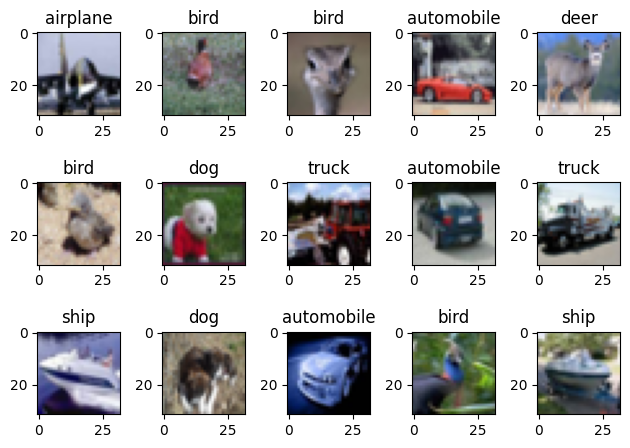

In [5]:
import cifar10
cifar_root_dir = 'cifar-10-batches-py'
_, _, X_test, y_test = cifar10.load_ciaf10(cifar_root_dir)
indices = np.random.choice(len(X_test), 15)

display_images, display_labels = X_test[indices], y_test[indices]
for idx, (img, label) in enumerate(zip(display_images, display_labels)):
    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(cifar10.LABELS[label])
    plt.tight_layout()
plt.show()

## Image classification using a linear classifier in pytorch




Image classification refers to the problem of automatically assigning a label (a class) to an image $X_i$. As classification is a supervised learning problem, each image is assigned a ground truth label $y_i \in \{1, 2, ..., C\}$.


Today you will implement and train the simplest possible artificial neural network using pytorch.
A linear classifier uses a function $f$ to map an input image $X_i \in R^{H\times W\times 3}$ into a vector of C class scores  $\hat y_i \in R^C$:


\begin{equation}
f(X_i) = X_i \cdot W + b
\end{equation}


The learnable parameters of the classifier are the weight matrix $W$ and the bias vector $b$. Using the bias trick the bias term can be included in the weight matrix.


During the training process, the values of the weight matrix are learned by minimizing a loss function (that penalizes the discrepancy between the predicted and the ground truth label).


In your implementation, the bias trick is used so the bias value is already added in the weight matrix. In the file _train.py_:




```
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
```


## Implementation


[Pytorch](https://pytorch.org/) is a powerful machine learning framework widely used for computer vision and natural language processing applications that we'll be using this semester.
[Tensors](https://pytorch.org/docs/stable/tensors.html) are the main data abstraction from pytorch; similar to numpy arrays, they represent multi-dimensional arrays of a single data type.
You can think of a tensor as consisting of some data, and then some metadata describing the size of the tensor, the type of the elements it contains (dtype) and what device the tensor lives on (CPU memory? CUDA memory?).


It is quite easy to transform tensors to and from numpy arrays:
- _from_numpy()_ function allows you to create a pytorch tensor from a numpy array.
- _numpy()_ functions allows you to convert a tensor to a numpy() array.


Also, you will use the function _item()_ to convert a tensor to a scalar python value.


Another important feature of pytorch is the _autograd_ module that provides classes and functions for automatic differentiation of arbitrary scalar valued functions. This module is really easy to use, you only need to declare Tensor's for which gradients should be computed by setting the _requires_grad_ attribute of a tensor to True.
As you know, most machine learning models are trained using the gradient descent algorithm. This is a first-order iterative optimization algorithm used to find the minimum of a differentiable function: the main idea is to take repeated steps in the opposite direction of the gradient  of the function at the current point (i.e. in the direction of steepest descent).






### Softmax classification


We'll follow an object oriented approach to solve this problem.
All the code related to the softmax classifier will be implemented in the class *SoftmaxClassifier* (defined in the script _softmax.py_).


The _SoftmaxClassifier_ class contains in the  attribute _self.W_ the weight matrix that will be learned during the training process.  


The class comprises the following methods:


| Method                               | Description |
| ----------- | ----------- |
| initialize()      | This function randomly initializes the weights of the linear classifier.    |
| fit(X_train, y_train, **kwargs)      | This function will learn the weights of the model based on the training data samples (X_train) and their corresponding ground truth (y_train)       |
|  predict(X)                | This function will return the classifier's prediction (the predicted class) for the data passed as parameter.        |
|  predict_proba(X)                | This function will return the classifier's predictions for the data passed as parameters.        |
|  save(path)   | This function will dump the weights of the classifier in the path specified as parameter.        |
|  load(load)   | This function will load the classifier's weights from the path specified as parameter      |


Feel free to add any additional helper methods if needed.


#### Initialization and persistence
* The constructor of this class takes as input the flattened size of the input image and the number of output classes, sets the corresponding class variables and calls the _init()_ method.
* fill in the _initialize()_ method. You figure out the shape of the weight matrix based on the input shape and the number of classes. Initialize the weight matrix with small random variables.
__The bias trick is already implemented__!
* fill in the _save_ and _load_ functions. In these functions you should just dump and restore, respectively, the weight matrix to/from the specified file.


#### Inference - the _predict_ and _predict\_proba_ methods


The inference is quite simple. You just need to compute the dot product between the input and the weight matrix.
You will implement two inference methods:
* _predict_ - this will just return the predicted class label. So you just need to compute the dot product and take the argmax of the result.
* _predict\_proba_ - this will return the class probabilities. So after computing the dot product, you also need to apply the softmax function on the result to normalize it to a probability distribution.


If you implement this correctly, the _SoftmaxClassifier_ can be used to make predictions, but of course they are not very accurate as we haven't trained the model yet.



In [ ]:
files.view('lab2/softmax.py')

In [6]:
from softmax import SoftmaxClassifier
num_pixels = np.prod(X_test[0].shape)
cls = SoftmaxClassifier(num_pixels+1, len(cifar10.LABELS))

test_example = torch.from_numpy(np.append(X_test[0].flatten(), 1.0)).float()
test_example = test_example[None, :]
print('predicted class ', cifar10.LABELS[cls.predict(test_example)], cls.predict(test_example))
print('probas: ', cls.predict_proba(test_example).detach().numpy())

predicted class  dog tensor(5)
probas:  [[3.3334387e-26 5.5963311e-29 1.8984871e-20 4.0632748e-22 2.1051116e-32
  1.0000000e+00 1.2529682e-34 1.0322457e-18 5.6308995e-27 1.2830654e-23]]


#### Training - the _fit_ method

The training process is implemented in the function _fit_ : here we are interested in finding the values for the weight matrix such that the classifier gives accurate predictions.

The loss function for the softmax classifier is defined as:

\begin{equation}
L_i = - \sum_{i=1}^{C} log(\hat{y\_pred}_i)\cdot y_i.
\end{equation}

, where $\hat{y_p}_i$ are the probabilities returned by the classifier for the ith sample and $y_i$ is the corresponding ground truth (as one hot encoding).

So in the ``cross_entropy`` function you just take the negative of the logarithm of the predicted probability for the ground truth class.

In the case of the softmax classifier $\hat{y\_pred}_i$ is always a value in the interval [0, 1] (we use the softmax function to normalize the logits into a probability distribution).
When the probability of the ground truth class is small (i.e. close to 0), the loss will be very high (theoretically, infinite) [log(0) = -inf]. On the other hand, when the probability of the correct class will be high (i.e. close to 1), then the loss will be close to 0 [log(1) = 0].

For numerical staibility instead of using softmax, we'll use the log softmax.

In the function `log_softmax` implement the following:
\begin{equation}
log\_softmax(x_i) =  log(\frac{e^{x_i}}{\sum_{j}e^{x_j}}) = x_i + log(\sum_j e^x_j)
\end{equation}

Then, in the ``fit`` method:
\begin{equation}
y\_pred_i = f(x_i)
\end{equation}

\begin{equation}
\hat{y\_pred_i} =  log\_softmax(y\_pred_i)
\end{equation},

and take the cross entropy loss between $\hat{y\_pred_i}$ and $y_i$ to compute the data loss.

For this we need two steps:
1. we need to define a loss function that quantifies our
how well is the classifier doing on the training data. The loss function that we will use is the **cross entropy loss**.
Remember from the lecture that, in order to avoid overfitting, a regularization term is added to the loss function.
You will implement the $L_2$ regularization, in which you also add the  sum of squares of all of the feature weights to the loss.


2. we need an algorithm to efficiently find the
parameters that minimize the loss function.

Pytorch provides a powerful feature, _autograd_: it allows for the rapid and easy computation of multiple partial derivatives (also referred to as gradients) over a complex computation. This operation is central to backpropagation-based neural network learning.

You can follow [this](https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html) post for more details about how autograd works.
We'll cover autograd in more detail in the next labs.

For now, we'll be using it to make your life easier when implementing gradient descent to train the softmax classifier. In gradient descent, the idea is to take repeated steps in the opposite direction of the gradient of the loss function at the current point. The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at a time, and iterating backward from the last layer to avoid redundant calculations of intermediate terms in the chain rule.

To signal autograd that it should collect the gradients of a tensor, you need to pass the parameter _requires_grad=True_ when creating it or call the method _requires_grad_()_ on a tensor.

To __start the backpropagation__ with autograd, you just need to call the _backward()_ function on the loss tensor (a scalar).  
Autograd calculates and stores the gradients for each model parameter in the tensors' _grad_ field.

Let's see how a custom training loop looks in pytorch:

```python
lr = 0.05  # learning rate: what is the size of the step that we will take in the opposite direction of the gradient
epochs = 32  # how many epochs (passes through the traing data) we'll peform
bs = 32 # batch size:  we'll update the parameters after seeing several examples (a batch of data)

for epoch in range(epochs):    
    for ii in range((X_train.shape[0] - 1) // bs + 1):  # in batches of size bs
        start_idx = ii * bs  # we are ii batches in, each of size bs
        end_idx = start_idx + bs  # get bs examples

        # get the training training examples xb, and their coresponding annotations
        xb = X_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]

        # apply the model on the training examples
        pred = predict_proba(xb)

        # compute the loss function
        loss = cross_entropy_loss(pred, yb)

        # start backpropagation: calculate the gradients with a backwards pass
        loss.backward()

        # update the parameters
        with torch.no_grad():  # we don't want to track gradients
            # take a step in the negative direction of the gradient, the learning rate defines the step size
            weights -= weights.grad * lr

            # ATTENTION: you need to explictly set the gradients to 0 (let pytorch know that you are done with them).
            weights.grad.zero_()
            
``




Implement the fit method.

## Putting it all together


By now you have implemented all the blocks needed to train a softmax classifier. Now it is time to train the classifier using different hyperparameters.




Try different values for the hyper-parameters of the classifier (the learning rate $\lambda$ and the regularization strength $\rho$).
The _train.py_ script contains the code that you will use for training and comparing different settings for  $\lambda$ and $\rho$.


Finally, after you trained a classifier display the learned weights for each of the classes in the cifar10 dataset. Intuitively, each row in the weight matrix would be considered as "template" for that class.


In [ ]:
files.view('lab2/train.py')

In [1]:
import os
import sys
import torch
import cifar10
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from softmax import SoftmaxClassifier

cifar_root_dir = 'cifar-10-batches-py'

# load cifar10 dataset
X_train, y_train, X_test, y_test = cifar10.load_ciaf10(cifar_root_dir)

# convert the training and test data to floating point
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Reshape the training data such that we have one image per row
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# pre-processing: subtract mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image

# Bias trick - add 1 to each training example
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# convert everything to tensors
X_train, y_train, X_test, y_test = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

X_train = X_train.float()
X_test = X_test.float()


if not os.path.exists('train'):
    os.mkdir('train')

best_acc = -1
best_cls_path = ''


input_size_flattened = reduce((lambda a, b: a * b), X_train[0].shape)

# the batch size
batch_size = 200
# number of training steps per training process
train_epochs = 50


lr = 0.007 # change the value - hyperparameter tuning
reg_strength = 0.007 # change the value - hyperparameter tuning

cls = SoftmaxClassifier(input_shape=input_size_flattened, num_classes=cifar10.NUM_CLASSES)
history = cls.fit(X_train, y_train, lr=lr, reg_strength=reg_strength,
        epochs=train_epochs, bs=batch_size)

with torch.no_grad():
  y_train_pred = cls.predict(X_train)
  y_val_pred = cls.predict(X_test)

train_acc = torch.mean((y_train == y_train_pred).float())

test_acc = torch.mean((y_test == y_val_pred).float())
sys.stdout.write('\rlr {:.4f}, reg_strength{:.2f}, test_acc {:.2f}; train_acc {:.2f}'.format(lr, reg_strength, test_acc, train_acc))
cls_path = os.path.join('train', 'softmax_lr{:.4f}_reg{:.4f}-test{:.2f}.npy'.format(lr, reg_strength, test_acc))
cls.save(cls_path)


plt.plot(history)
plt.show()

best_softmax = cls


plt.rcParams['image.cmap'] = 'gray'
# now let's display the weights for the best model
weights = best_softmax.get_weights((32, 32, 3))

w_min = np.amin(weights)
w_max = np.amax(weights)

for idx in range(0, cifar10.NUM_CLASSES):
    plt.subplot(2, 5, idx + 1)
    # normalize the weights
    template = 255.0 * (weights[idx, :, :, :].squeeze() - w_min) / (w_max - w_min)
    template = template.astype(np.uint8)
    plt.imshow(template)
    plt.title(cifar10.LABELS[idx])

plt.show()


# TODO your code here
# use the metrics module to compute the precision, recall and confusion matrix for the best classifier
# end TODO your code here

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

num_classes = cifar10.NUM_CLASSES

# compute confusion matrix using scikit-learn
sk_conf_mat_train = confusion_matrix(y_train.numpy(), y_train_pred.numpy())
sk_conf_mat_test = confusion_matrix(y_test.numpy(), y_val_pred.numpy())

# compute precision using scikit-learn
sk_precision_train = precision_score(y_train.numpy(), y_train_pred.numpy(), average='macro', zero_division=1)
sk_precision_test = precision_score(y_test.numpy(), y_val_pred.numpy(), average='macro', zero_division=1)

# compute recall using scikit-learn
sk_recall_train = recall_score(y_train.numpy(), y_train_pred.numpy(), average='macro')
sk_recall_test = recall_score(y_test.numpy(), y_val_pred.numpy(), average='macro')

# compute F1-score using scikit-learn
sk_f1_train = f1_score(y_train.numpy(), y_train_pred.numpy(), average='macro')
sk_f1_test = f1_score(y_test.numpy(), y_val_pred.numpy(), average='macro')

# compute accuracy using scikit-learn
sk_accuracy_train = accuracy_score(y_train.numpy(), y_train_pred.numpy())
sk_accuracy_test = accuracy_score(y_test.numpy(), y_val_pred.numpy())

# print the metrics using scikit-learn
print("Scikit-learn Confusion Matrix (Train):\n", sk_conf_mat_train)
print("Scikit-learn Precision (Train):", sk_precision_train)
print("Scikit-learn Recall (Train):", sk_recall_train)
print("Scikit-learn F1-Score (Train):", sk_f1_train)
print("Scikit-learn Accuracy (Train):", sk_accuracy_train)

print("\nScikit-learn Confusion Matrix (Test):\n", sk_conf_mat_test)
print("Scikit-learn Precision (Test):", sk_precision_test)
print("Scikit-learn Recall (Test):", sk_recall_test)
print("Scikit-learn F1-Score (Test):", sk_f1_test)
print("Scikit-learn Accuracy (Test):", sk_accuracy_test)


hyperparameters: lr 0.0070, reg 0.0070, epochs 50.00


RuntimeError: expected scalar type Long but found Int

## Refactoring using torch components


Luckily pytorch provides implementation for most of the layers used in modern machine learning, as well as loss functions, metrics, and optimization algorithms.


To define a model, you must extend the torch.nn.Module class which is the base class for all the neural network modules. In the constructor, you define the layers (and their properties) that comprise your module. The line


Another important function that you need to override is the forward() function in which you specify computation performed at every call (i.e. how are layers chained and how does the data flow over the computational graph). In other words, this defines the forward pass through your model.



In [2]:
import torch
from torch import nn

class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3072, 10)

    def forward(self, x):
        return self.linear(x)

the `nn.Linear` layer is a "child"
of the `Cifar10Classifier`,
and the weight matrix is abstracted (you don't have direct access to it).


In [3]:
# Example usage:
model = Cifar10Classifier()
print(*list(model.children()))

Linear(in_features=3072, out_features=10, bias=True)


But you can still access the parameters of the model (the bias trick is not used in this case):

In [4]:
print(*list(model.parameters()), sep="\n")

Parameter containing:
tensor([[-0.0015, -0.0121, -0.0154,  ...,  0.0074, -0.0117, -0.0103],
        [-0.0019,  0.0152,  0.0067,  ..., -0.0061,  0.0168,  0.0137],
        [ 0.0101,  0.0094,  0.0133,  ..., -0.0161,  0.0022,  0.0037],
        ...,
        [-0.0066, -0.0065, -0.0115,  ...,  0.0158, -0.0171, -0.0170],
        [ 0.0079,  0.0025, -0.0067,  ..., -0.0048, -0.0074, -0.0105],
        [ 0.0127, -0.0083,  0.0059,  ..., -0.0070, -0.0139, -0.0179]],
       requires_grad=True)
Parameter containing:
tensor([-0.0129,  0.0016, -0.0079,  0.0005, -0.0124, -0.0089,  0.0084, -0.0178,
        -0.0089, -0.0166], requires_grad=True)


Torch also provides several loss functions that you can use in the `torch.nn.functional` model. Let's drop the log_softmax and cross_entropy function that you wrote and use `torch.nn.functional.cross_entropy`[function](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html).
Pay attention: you don't need to apply the log-softmax on the prediction of the model as the function operates directly on  unnormalized logits.

In [5]:
loss_func = torch.nn.functional.cross_entropy

The optimization process (applying gradients to find the parameters and resetting those gradients to zero) can be handled more elegantly using predefined pytorch classes and operations.


You just need a subclass of the torch.optim.Optimizer, and it will automatically update the parameters of our model. In this example, we'll be using the Adam optimizer (which will be covered in detail in the lectures).


In [6]:
from torch import optim

def configure_optimizer(model: nn.Module) -> optim.Optimizer:
    return optim.Adam(model.parameters(), lr=3e-4)


Let's reload the data:

In [7]:
import cifar10
cifar_root_dir = 'cifar-10-batches-py'

# load cifar10 dataset
X_train, y_train, X_test, y_test = cifar10.load_ciaf10(cifar_root_dir)

# convert the training and test data to floating point
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Reshape the training data such that we have one image per row
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# pre-processing: subtract mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image

# convert everything to tensors
X_train, y_train, X_test, y_test = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

X_train = X_train.float()
X_test = X_test.float()

Now, the training loop will be much simpler:

In [8]:
import tqdm
model = Cifar10Classifier()
opt = configure_optimizer(model)


print("before training:", loss_func(model(X_test), y_test), sep="\n\t")
epochs = 50
bs = 64
num_train = X_train.shape[0]

epochs = tqdm.tqdm(range(epochs), desc="Epochs")

for epoch in epochs:
    for ii in range((num_train - 1) // bs + 1):
        start_idx = ii * bs
        end_idx = start_idx + bs
        xb = X_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]
        pred = model(xb) # call the forward function
        loss = loss_func(pred, yb) # apply the loss function

        loss.backward() # start the backpropagation and compute the gradients
        opt.step() # apply the parameter update
        opt.zero_grad() # zero out the gradients

model.eval()
with torch.no_grad():
    y_train_pred = torch.argmax(model(X_train), dim=1)
    train_acc = accuracy_score(y_train.numpy(), y_train_pred.numpy())

    y_test_pred = torch.argmax(model(X_test), dim=1)
    test_acc = accuracy_score(y_test.numpy(), y_test_pred.numpy())
print('Train acc ', train_acc.detach().numpy(), ' test acc ', test_acc.detach().numpy())

print("after training:", loss_func(model(X_test), y_test), sep="\n\t")

RuntimeError: expected scalar type Long but found Int

## Classifier evaluation

After the training process, you want to evaluate the model on the test set, such that you can get an idea on how well your model will perform on unseen data.
Ideally the classes in the test set should be balanced (i.e. you should have the same number of samples for each one of the classes).

### Confusion matrix and classification metrics

The confusion matrix can be considered the foundation stone for evaluating a classifier. As the name states, it's a simple way of visualising whether/how the model is confusing the classes.

Each row of the confusion matrix represents the instances of the ground truth class, while each column represents the instances of the predicted class.

<img src="https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg"/>

Based on the confusion matrix, you can compute different classification metrics:
* *accuracy*: this is simply the ratio between the correctly classified samples (either positive or negative) and the total number of samples;
* _precisi**on**_ : this metric measures the ability of the classifier to capture **only** relevant samples;
* _rec**all**_ : this metric measures the ability of the classifier to spot **all** positive samples.

As you may have noticed, it is not possible to maximize precision and recall at the same time, as one comes at the cost of another.
Therefore, the $F_1$ score -- the harmonic mean between precision and recall -- was defined to combine these two metrics into a single numerical value.

\begin{equation}
F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}
\end{equation}

In the file *metrics.py* you should fill in the code for computing the accuracy, precision, recall and f1-score of your classifier.

One challenge when implementing these metrics is that you are not allowed to use any repetitive loops (only numpy vectorization).

Of course, pytorch provides functions for all these metrics, but for didactical puropose and to gain a deeper understanding of nd-arrays and tenors you should implement them from scratch.



Compute the metrics on the best classifier you obtained so far.